In [2]:
%reload_ext autoreload
%autoreload 2
import bpe_surgery
import evaluate
import utils
import time
import pickle
import os
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt

/home/zaid/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [51]:
gold_tokens = utils.get_gold_segmentations(dataset="/home/zaid/camelTB")
corpus = " ".join(list(gold_tokens))

In [4]:
evaluate_names = ["segmentation", "compression factor", "training speed", "inference speed",
                                   "num of tokens","token length"]
vocab_sizes = [300, 500, 1000, 5000]

In [52]:
results = {}

for vocab_size in vocab_sizes:
    results_per_vocab = {}
    tokenizers = [bpe_surgery.bpe(vocab_size, lang='ar',), 
              bpe_surgery.bpe(vocab_size, morph = True, lang='ar', morph_with_sep=True)]
    for tokenizer in tokenizers:
        print("*" * 30)
        if tokenizer.name in os.listdir("."):
            print(f"{tokenizer.name} already trained ...")
            continue 
        tokenizer_index = vocab_sizes.index(vocab_size)
        if tokenizer_index > 0:
            prev_tokenizer_vocab_size = vocab_sizes[tokenizer_index - 1]
            prev_tokenizer_name = "bpe"
            if tokenizer.morph:
                prev_tokenizer_name += "-morph"
            prev_tokenizer_name += f"-ar-{prev_tokenizer_vocab_size}"
            try:
                tokenizer.load(prev_tokenizer_name)
            except:
                print("error in loading prev tokenizer")
        print(f"training {tokenizer.name}")
        start_time = time.time()
        tokenizer.train(file = 'test_ar.txt')
        end_time = time.time()
        print('evaluating ... ')
        r1 = evaluate.evaluate_on_segmentation(corpus, gold_tokens, tokenizer)
        r2 = evaluate.evaluate_on_compression_factor(corpus, tokenizer)
        r3 = end_time - start_time
        r4 = evaluate.evaluate_on_inf_speed(corpus, tokenizer)
        r5 = evaluate.evaluate_on_num_tokens(corpus, tokenizer)
        r6 = evaluate.evaluate_on_token_length(tokenizer)

        results_per_vocab[tokenizer.name] = [{"segmentation": r1}, {"compression factor":r2}, {"training speed":r3}, {"inference speed":r4},
                                   {"num of tokens":r5}, {"token length":r6}]
        tokenizer.save('.')
        with open(f"{tokenizer.name}/results.pl", 'wb') as handle:
            pickle.dump(results_per_vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    results[vocab_size] = results_per_vocab

******************************
bpe-ar-300 already trained ...
******************************
bpe-morph-ar-300 already trained ...
******************************
bpe-ar-500 already trained ...
******************************
training bpe-morph-ar-500
Continue pretraining from vocab_size :  300


  0%|          | 0/200 [00:00<?, ?it/s]

vocab size reached
evaluating ... 


  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

******************************
training bpe-ar-1000
Continue pretraining from vocab_size :  500


  0%|          | 0/500 [00:00<?, ?it/s]

vocab size reached
evaluating ... 


  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

******************************
training bpe-morph-ar-1000
Continue pretraining from vocab_size :  500


  0%|          | 0/500 [00:00<?, ?it/s]

vocab size reached
evaluating ... 


  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

******************************
training bpe-ar-5000
Continue pretraining from vocab_size :  1000


  0%|          | 0/4000 [00:00<?, ?it/s]

vocab size reached
evaluating ... 


  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

******************************
training bpe-morph-ar-5000
Continue pretraining from vocab_size :  1000


  0%|          | 0/4000 [00:00<?, ?it/s]

vocab size reached
evaluating ... 


  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/14322 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

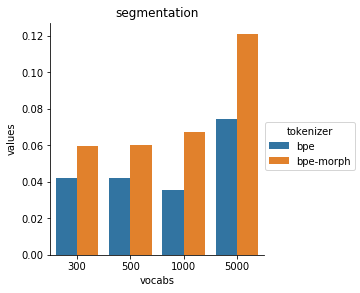

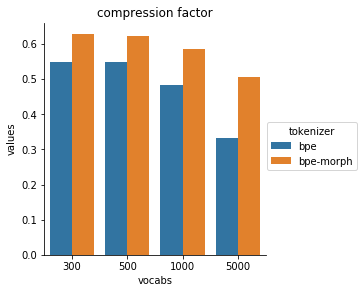

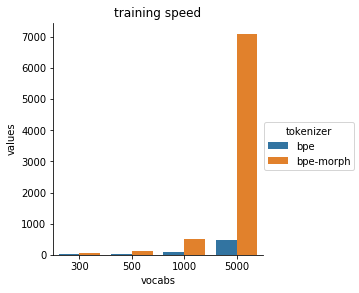

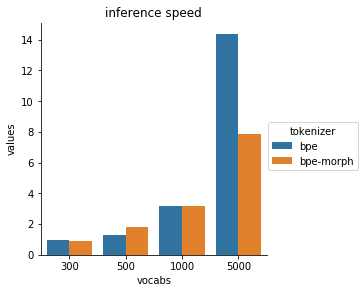

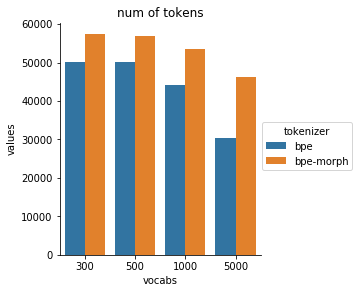

                  vocabs
tokenizer values        
bpe       1           69
          2          166
          3           33
          4           26
          5            4
bpe-morph 1           69
          2          171
          3           48
          4           10


ValueError: Could not interpret input 'values'

In [21]:
foulders = [a for a in os.listdir() if os.path.isdir(a) and 'bpe' in a]
for i, evaluate_name in enumerate(evaluate_names):
    names = []
    values = [] 
    vocabs = []
    for vocab_size in vocab_sizes:
        for tokenizer_name in foulders: 
            if str(vocab_size) in tokenizer_name.split('-'):
                with open(f'{tokenizer_name}/results.pl', 'rb') as handle:
                    results_per_vocab = pickle.load(handle)
                names.append(tokenizer_name.replace(f'-{vocab_size}', '').replace('-ar', ''))
                values.append(list(results_per_vocab[tokenizer_name][i].values())[0])
                vocabs.append(vocab_size)

    data = pd.DataFrame({'tokenizer':names, 'values':values, 'vocabs':vocabs})
    if i < 5 :
        sns.factorplot(x='vocabs', y='values', hue='tokenizer', data=data, kind='bar')
        plt.title(evaluate_name)
        plt.show()
    else:
        expanded_df = data.explode('values', ignore_index = True)
        for vocab_size in vocab_sizes:
            df = expanded_df[expanded_df['vocabs'] == vocab_size].groupby(['tokenizer', 'values']).count()
            print(df)
            sns.factorplot(x='values', y='vocabs', hue='tokenizer', data=df, kind='bar')
            plt.title(f'{evaluate_name} for vocab {vocab_size}')
            plt.show()

In [26]:
expanded_df = data.explode('values')
df = expanded_df[expanded_df['vocabs'] == 300].groupby(['tokenizer', 'values']).count()
d

pandas.core.frame.DataFrame

In [ ]:
results = {}
with open(f'{path}/tok.model', 'rb') as handle:
    self.vocab, self.merges = pickle.load(handle)

,tokenizer,values,vocabs
0,bpe,1,300
1,bpe,1,300
2,bpe,1,300
3,bpe,1,300
4,bpe,1,300
...,...,...,...
591,bpe-morph,2,300
592,bpe-morph,2,300
593,bpe-morph,3,300
594,bpe-morph,4,300


In [80]:
pd.__version__

'0.23.4'

In [81]:
!pip3 install --upgrade pandas

     |████████████████████████████████| 9.5 MB 567 kB/s            
  Attempting uninstall: pandas
    Found existing installation: pandas 0.23.4
    Uninstalling pandas-0.23.4:
      Successfully uninstalled pandas-0.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.12.0 requires pandas<=0.23.4,>=0.20.3, but you have pandas 1.1.5 which is incompatible.
